In [307]:
# prep: import modules and get pwd
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import seaborn as sns
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [308]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [309]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

## Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.

In [310]:
query = '''select rental_date, film_id
from rental
join inventory using(inventory_id)
where rental_date like '2005%%';'''

data = pd.read_sql_query(query, engine)
data.head()

,rental_date,film_id
0,2005-05-24 22:53:30,80
1,2005-05-24 22:54:33,333
2,2005-05-24 23:03:39,373
3,2005-05-24 23:04:41,535
4,2005-05-24 23:05:21,450


## Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [311]:
query_title = '''select film_id, rental_date, rental_duration, rating, length, actor_id, category_id, special_features, rental_rate
    from inventory
    join rental using(inventory_id)
    join film_actor using (film_id)
    join film using(film_id)
    join film_category using(film_id)
    group by inventory_id;'''

data = pd.read_sql_query(query_title, engine)
data.head()

from datetime import datetime

data['rented'] =(data['rental_date']>'2005-07-31') & (data['rental_date']<'2005-09-01')

print(data.dtypes)

data.isna().sum()

film_id                      int64
rental_date         datetime64[ns]
rental_duration              int64
rating                      object
length                       int64
actor_id                     int64
category_id                  int64
special_features            object
rental_rate                float64
rented                        bool
dtype: object


film_id             0
rental_date         0
rental_duration     0
rating              0
length              0
actor_id            0
category_id         0
special_features    0
rental_rate         0
rented              0
dtype: int64

## Read the data into a Pandas dataframe.

In [312]:
print(data.shape)

data.head()

(4567, 10)


,film_id,rental_date,rental_duration,rating,length,actor_id,category_id,special_features,rental_rate,rented
0,19,2005-08-02 01:16:59,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,True
1,19,2005-06-20 20:35:28,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False
2,19,2005-05-28 12:08:37,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False
3,19,2005-08-01 11:25:28,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,True
4,19,2005-06-16 15:51:52,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False


## Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [313]:
# i can not change anything about the film ID. we will scale these with other numericals
data["film_id"]

0        19
1        19
2        19
3        19
4        19
       ... 
4562    989
4563    989
4564    989
4565    989
4566    989
Name: film_id, Length: 4567, dtype: int64

In [314]:
# i dont need the whole date, so ill reduce it to the month only
data["rental_date"] = data["rental_date"].dt.month

data.head()

,film_id,rental_date,rental_duration,rating,length,actor_id,category_id,special_features,rental_rate,rented
0,19,8,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,True
1,19,6,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False
2,19,5,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False
3,19,8,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,True
4,19,6,6,PG,113,5,1,"Commentaries,Deleted Scenes,Behind the Scenes",0.99,False


In [315]:
#to be included in the scaling of the numericals i need to convert this from date to numerical

data["rental_date"] = data["rental_date"].to_numeric

data.dtypes

AttributeError: 'Series' object has no attribute 'to_numeric'

In [316]:
data["rental_date"].value_counts()

7    1935
5    1154
6    1153
8     325
Name: rental_date, dtype: int64

In [317]:
#looking at this data i will one hot encode this
data["rating"].value_counts()

PG-13    1018
NC-17     944
PG        923
R         894
G         788
Name: rating, dtype: int64

In [318]:
data["actor_id"].value_counts()

12     134
5      122
14     121
7      121
13     115
      ... 
121      3
148      2
117      2
129      2
198      2
Name: actor_id, Length: 138, dtype: int64

In [319]:
# this seems like a long list. I want to only keep the 15 most popular actors in the list. The rest will be a other catagory with other.
list_of_actors = data['actor_id']
list_of_actors
# Let's count the freauency for each actor in the list
from collections import Counter

# Let's isolate the top 15
# most_common & counter found here : https://www.delftstack.com/howto/python/python-counter-most-common/
c = Counter(list_of_actors)
counter_15 = c.most_common(15)

# the output is a list of tuples (actor_id:frequency)
# We thus need to extract the actor_id's 
top_15 = []
for i in range(len(counter_15)):
    actor_top_15.append(counter_15[i][0])

# And the top 5 is
top_15

# data['actor_id'] = data['actor_id'].apply(lambda x: x if x in top_15 else 0)

[]

In [301]:
data["actor_id"] = data["actor_id"].astype('object')

data["actor_id"].value_counts()

0    4567
Name: actor_id, dtype: int64

In [264]:
X= data.drop(['rented'], axis=1)
y= data['rented']

In [265]:
X_num = X._get_numeric_data()

X_cat= X.select_dtypes(['object'])

print(X_num.columns)
print(X_cat.columns)


Index(['film_id', 'rental_date', 'rental_duration', 'length', 'category_id',
       'rental_rate'],
      dtype='object')
Index(['rating', 'actor_id', 'special_features'], dtype='object')


In [266]:
from sklearn.preprocessing import MinMaxScaler
MinMaxtransformer = MinMaxScaler().fit(X_num)
x_normalized = MinMaxtransformer.transform(X_num)
print(x_normalized.shape)
x_normalized = pd.DataFrame(x_normalized,columns=X_num.columns)
x_normalized.head()

(4567, 6)


,film_id,rental_date,rental_duration,length,category_id,rental_rate
0,0.018018,1.000000,0.75,0.482014,0.0,0.0
1,0.018018,0.333333,0.75,0.482014,0.0,0.0
2,0.018018,0.000000,0.75,0.482014,0.0,0.0
3,0.018018,1.000000,0.75,0.482014,0.0,0.0
4,0.018018,0.333333,0.75,0.482014,0.0,0.0


In [267]:
# one-hot encode the catagoricals

In [268]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder().fit(X_cat)
print(encoder.categories_)
encoded = encoder.transform(X_cat).toarray()
print(encoded)
cols = [colname for row in encoder.categories_ for colname in row]
cols
onehot_encoded = pd.DataFrame(encoded, columns=cols)
cols_to_drop = [row[0] for row in encoder.categories_]
cols_to_drop
onehot_encoded = onehot_encoded.drop(cols_to_drop,axis=1)
onehot_encoded.head()

onehot_encoded.shape

[array(['G', 'NC-17', 'PG', 'PG-13', 'R'], dtype=object), array([0], dtype=object), array(['Behind the Scenes', 'Commentaries',
       'Commentaries,Behind the Scenes', 'Commentaries,Deleted Scenes',
       'Commentaries,Deleted Scenes,Behind the Scenes', 'Deleted Scenes',
       'Deleted Scenes,Behind the Scenes', 'Trailers',
       'Trailers,Behind the Scenes', 'Trailers,Commentaries',
       'Trailers,Commentaries,Behind the Scenes',
       'Trailers,Commentaries,Deleted Scenes',
       'Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'Trailers,Deleted Scenes',
       'Trailers,Deleted Scenes,Behind the Scenes'], dtype=object)]
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4567, 18)

In [269]:
# concat the dataframe
X = pd.concat([x_normalized, onehot_encoded], axis=1)

X.head()

,film_id,rental_date,rental_duration,length,category_id,rental_rate,NC-17,PG,PG-13,R,...,Deleted Scenes,"Deleted Scenes,Behind the Scenes",Trailers,"Trailers,Behind the Scenes","Trailers,Commentaries","Trailers,Commentaries,Behind the Scenes","Trailers,Commentaries,Deleted Scenes","Trailers,Commentaries,Deleted Scenes,Behind the Scenes","Trailers,Deleted Scenes","Trailers,Deleted Scenes,Behind the Scenes"
0,0.018018,1.000000,0.75,0.482014,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.018018,0.333333,0.75,0.482014,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.018018,0.000000,0.75,0.482014,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.018018,1.000000,0.75,0.482014,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.018018,0.333333,0.75,0.482014,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


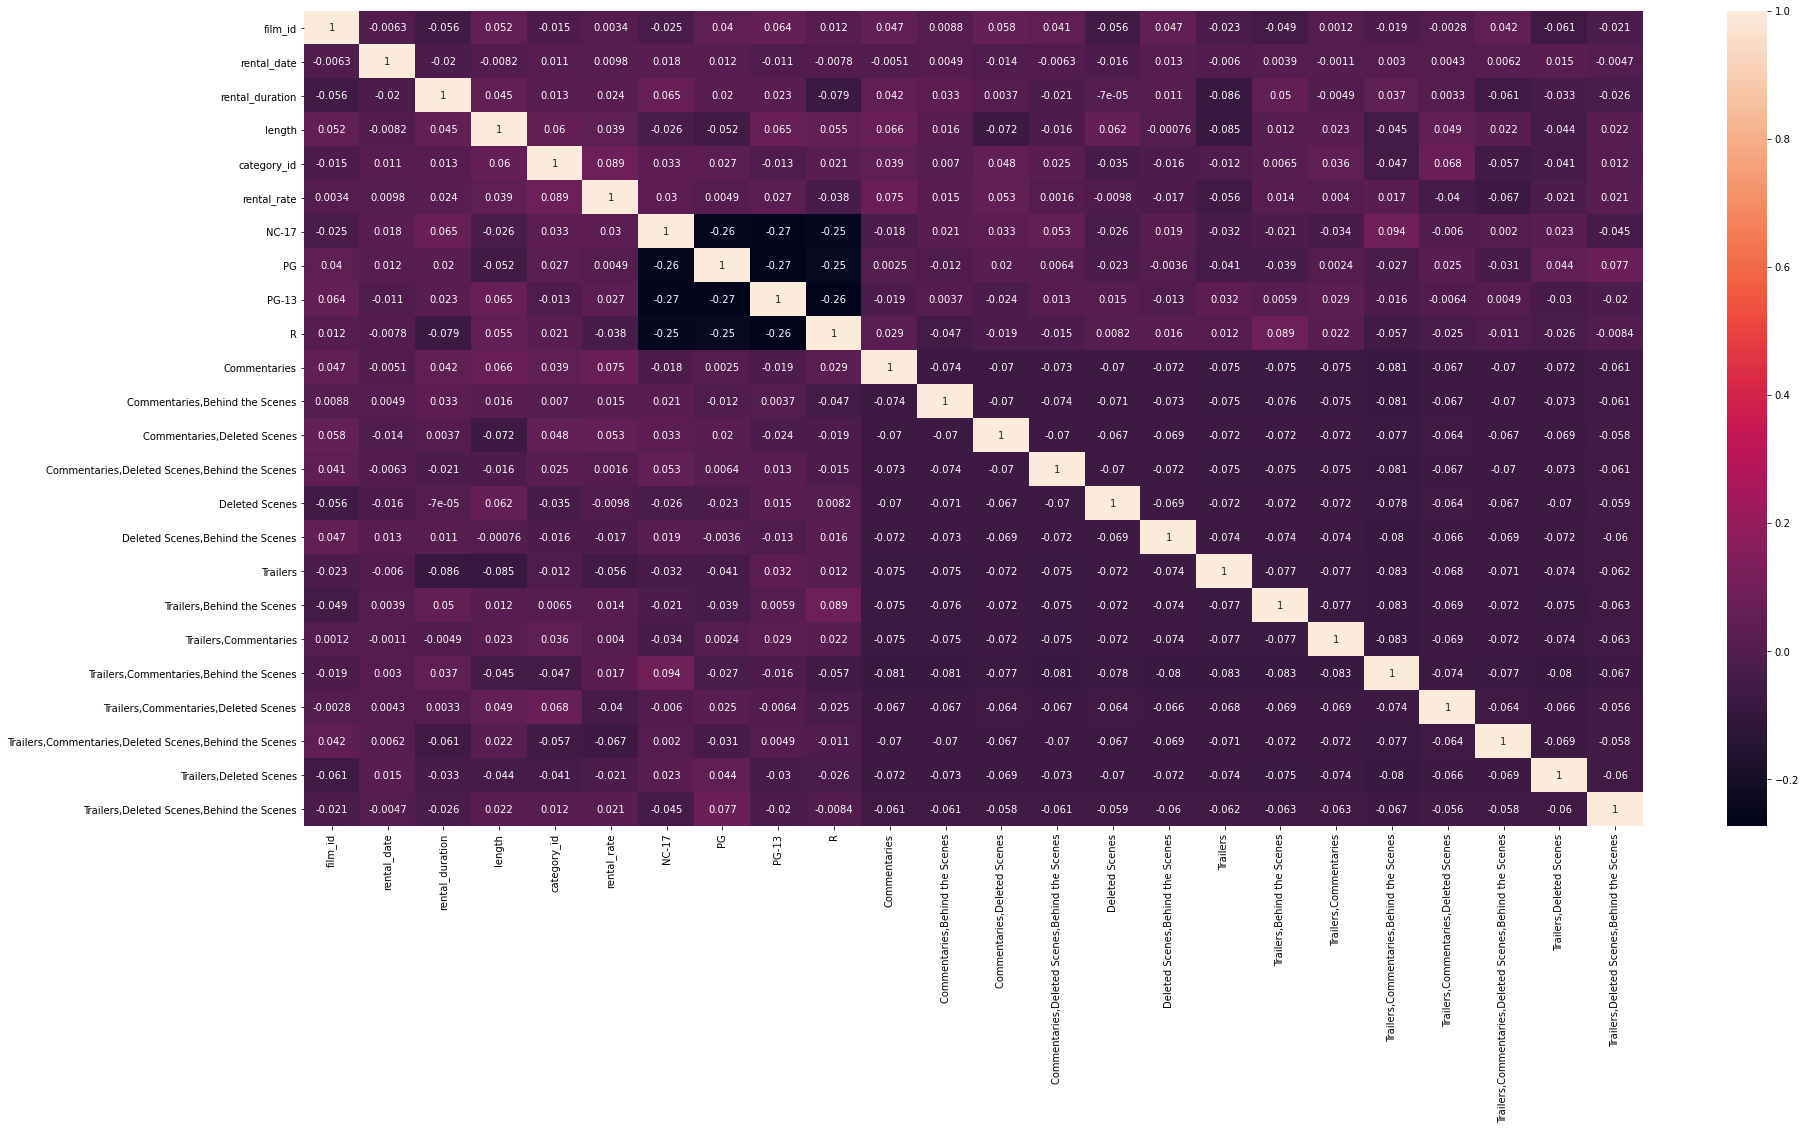

In [254]:
correlations_matrix = X.corr()
fig, ax = plt.subplots(figsize=(30,15))
sns.heatmap(correlations_matrix, annot=True)
plt.show()

## Create a logistic regression model to predict this variable from the cleaned data.

In [255]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=420)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3425, 24)
(1142, 24)
(3425,)
(1142,)


In [256]:
lm = linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [257]:
from sklearn.metrics import r2_score
predictions = lm.predict(X_train)
r2_score(y_train, predictions)

0.24638647213312592

In [258]:
predictions = lm.predict(X_test)
r2_score(y_test, predictions)

0.28918820937292866

In [259]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test,predictions))

0.26414557161373386

## Evaluate the results.

In [ ]:
# i've managed to make the worst model in history